In [60]:
import torchvision
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import pickle

import neo


In [61]:
cb_dict = dict()
fpath = '/users/ntolley/scratch/SEE_analysis/Analysis_June6_2023'
unit_idx = 0
stream_indices = [1, 0]
for file_idx, cb_idx in enumerate(range(1,2)):
    # Use neo module to load blackrock files
    experiment_dict = sio.loadmat(f'{fpath}/eventsCB{cb_idx}_Spike_June06.mat')
    nev = neo.io.BlackrockIO(f'{fpath}/SPKRH20230606_CB{cb_idx}_quiver4toyPKPK4Rotation_delay/derived/SPKRH20230606_CB{cb_idx}_quiver4toyPKPK4Rotation_delay001_RETVR_DSXII.nev')
    ns2 = neo.io.BlackrockIO(f'{fpath}/SPKRH20230606_CB{cb_idx}_quiver4toyPKPK4Rotation_delay/SPKRH20230606_CB{cb_idx}_quiver4toyPKPK4Rotation_delay001.ns2')

    sampling_rate_list = ns2.header['signal_channels'][['name','sampling_rate']]
    sampling_rate = 30000
    analog_sampling_rate = 1000
    camera_sampling_rate = 40

    # nev seg holds spike train information to extract
    nev_seg = nev.read_segment()
    tstart = nev_seg.t_start.item()
    tstop = nev_seg.t_stop.item()

    # Group spiketrain timestamps by unit id
    unit_timestamps = dict()
    for st in nev_seg.spiketrains:
        if st.annotations['unit_id'] == 1:
            unit_timestamps[unit_idx] = st.times
            unit_idx += 1

    # Grab indices for camera frames
    cam_trigger = ns2.get_analogsignal_chunk(channel_names=['FlirCam'], stream_index=stream_indices[file_idx]).transpose()[0]
    num_analog_samples = len(cam_trigger)
    trigger_val = 10000 # threshold where rising edge aligns frame, may need to tweak
    cam_frames = np.flatnonzero((cam_trigger[:-1] < trigger_val) & (cam_trigger[1:] > trigger_val))+1

    cb_dict[f'cb{cb_idx}'] = {'tstart': tstart, 'tstop': tstop, 'unit_timestamps': unit_timestamps,
                              'cam_frames': cam_frames, 'experiment_dict': experiment_dict}


In [66]:
cb_idx = 1
fpath = '/users/ntolley/scratch/SEE_analysis/Analysis_June6_2023'
experiment_dict = sio.loadmat(f'{fpath}/eventsCB{cb_idx}_Spike_June06.mat')
ev_ex = experiment_dict['eventsCB1']

In [67]:
tgtON = ev_ex['tgtON_C'][0][0][0]
gocON = ev_ex['gocON_C'][0][0][0]
gocOFF = ev_ex['gocOFF'][0][0][0]
stmv = ev_ex['stmv_C'][0][0][0]
contact = ev_ex['contact_C'][0][0][0]
endhold = ev_ex['endhold_C'][0][0][0]
gripori = ev_ex['GRIPORI_C'][0][0][0]
layout = ev_ex['LAYOUT_C'][0][0][0]
position = ev_ex['POSITION_C'][0][0][0]
reward = ev_ex['reward'][0][0][0]
error = ev_ex['error'][0][0][0]

In [69]:
cam_start = cam_frames[0] / analog_sampling_rate

In [70]:
cam_idx = 1
# video_path = '/users/ntolley/scratch/SEE_analysis/Anipose-Jun6-2023/videos-raw'
# video_fname = f'{video_path}/SpikeCam{cam_idx}_06-06-0905.avi'

video_path = '/users/ntolley/scratch/SEE_analysis/Anipose-Jun6-2023/videos-labeled'
video_fname = f'{video_path}/SpikeCam{cam_idx}_06-06-0905.mp4'

reader = torchvision.io.VideoReader(video_fname, 'video')

In [72]:
layout_frame_dict = dict()
for layout_idx in range(1,5):
    layout_filter = np.where(layout == layout_idx)[0]
    idx = layout_filter[0]

    reader.seek(contact[idx] - cam_start + 0.0)
    frame = next(reader)
    frame_data = frame['data'].numpy()
    layout_frame_dict[f'layout_{layout_idx}'] = frame_data
    np.save(f'../data/layout_frames/layout{layout_idx}_cam{cam_idx}.npy', frame_data)

/users/ntolley/.conda/envs/see/lib/python3.10/site-packages/torchvision/io/video_reader.py:233: UserWarning: Accurate seek is not implemented for pyav backend
  warnings.warn("Accurate seek is not implemented for pyav backend")


In [109]:
class model_cnn(nn.Module):
    def __init__(self, device='cpu'):
        super(model_cnn, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, stride=3)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=3)
        self.fc1 = nn.Linear(1008, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        print(x.shape)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [110]:
model = model_cnn()
model(torch.tensor(frame_data).float().unsqueeze(0))

torch.Size([1, 1008])


tensor([[-0.7477, -0.3712, -0.4764,  0.6727]], grad_fn=<AddmmBackward0>)

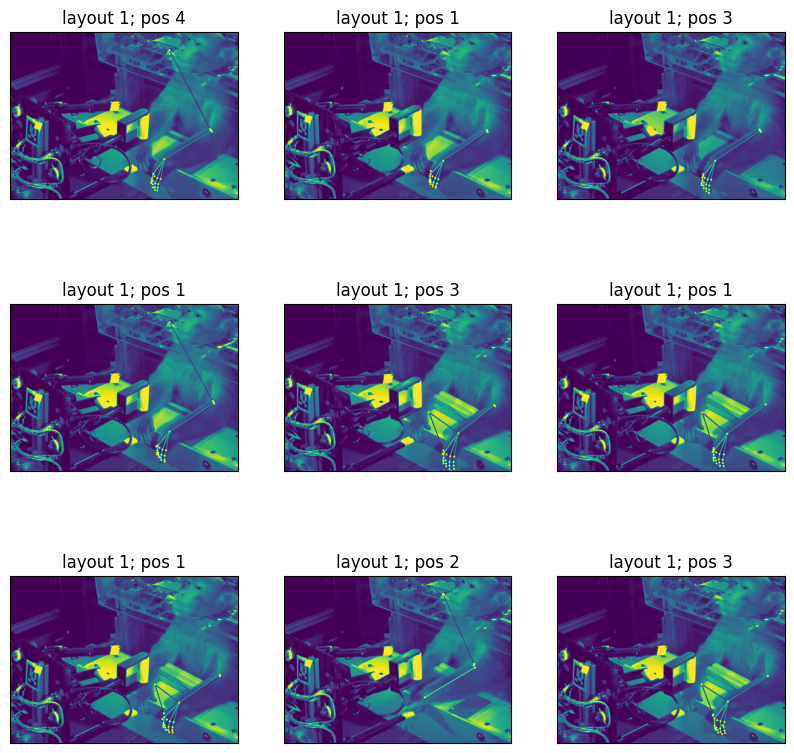

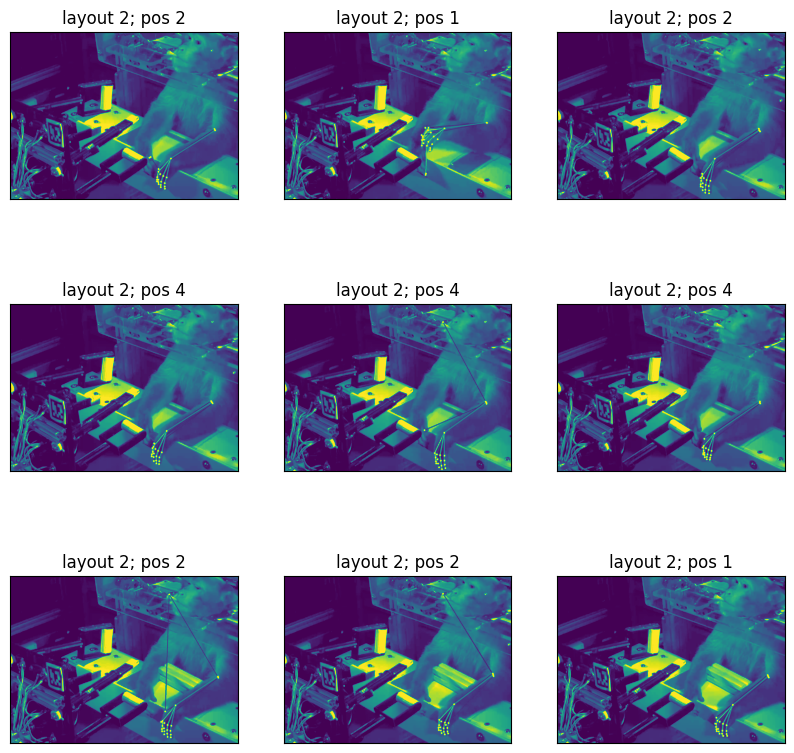

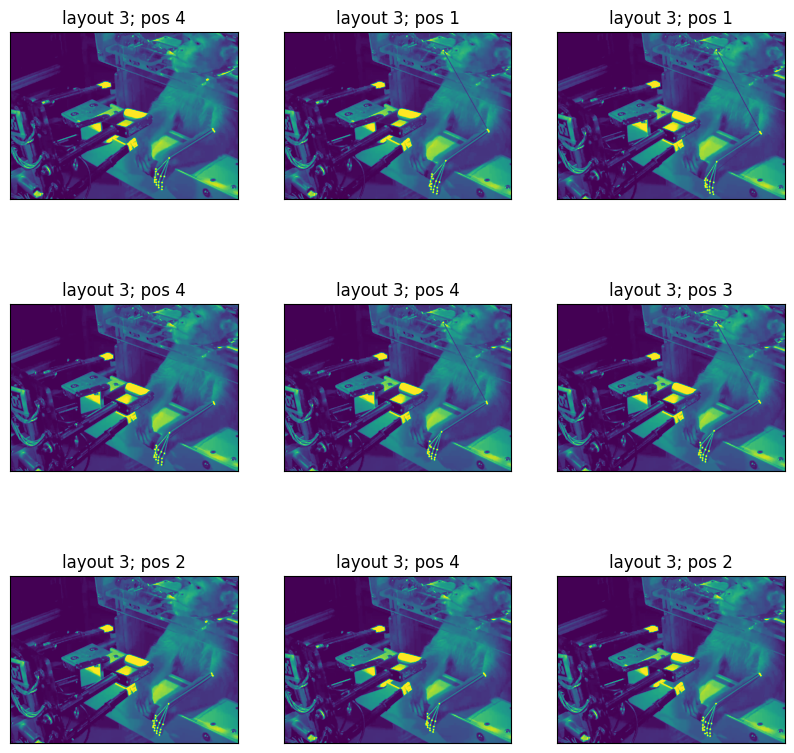

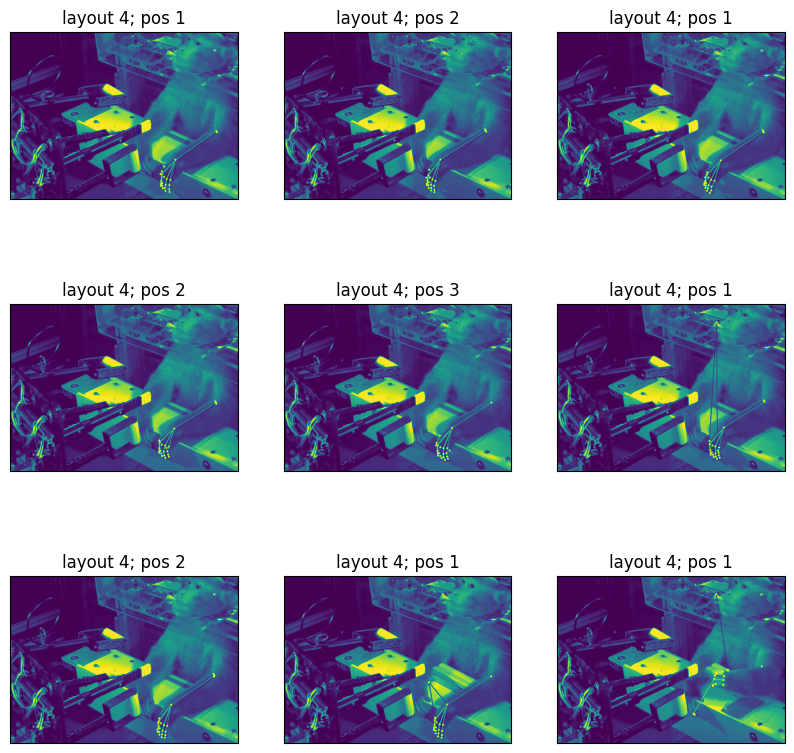

In [51]:
# for layout_idx in range(1,5):
#     plt.figure(figsize=(10,10))
#     layout_filter = np.where(layout == layout_idx)[0]
#     for plot_idx in range(9):
#         idx = layout_filter[plot_idx] 

#         plt.subplot(3, 3, plot_idx + 1)
#         reader.seek(contact[idx] - cam_start + 0.0)
#         frame = next(reader)
#         plt.imshow(frame['data'].numpy()[0,:,:])
#         plt.title(f'layout {layout_idx}; pos {position[idx]}')
#         plt.xticks([])
#         plt.yticks([])
#         #plt.tight_layout()
    

/users/ntolley/.conda/envs/see/lib/python3.10/site-packages/torchvision/io/video_reader.py:233: UserWarning: Accurate seek is not implemented for pyav backend
  warnings.warn("Accurate seek is not implemented for pyav backend")


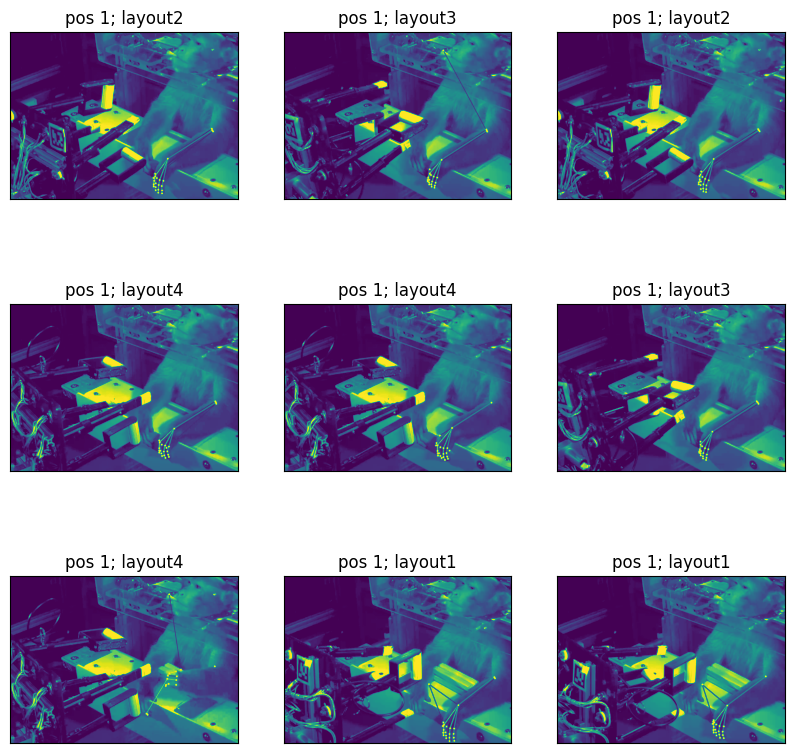

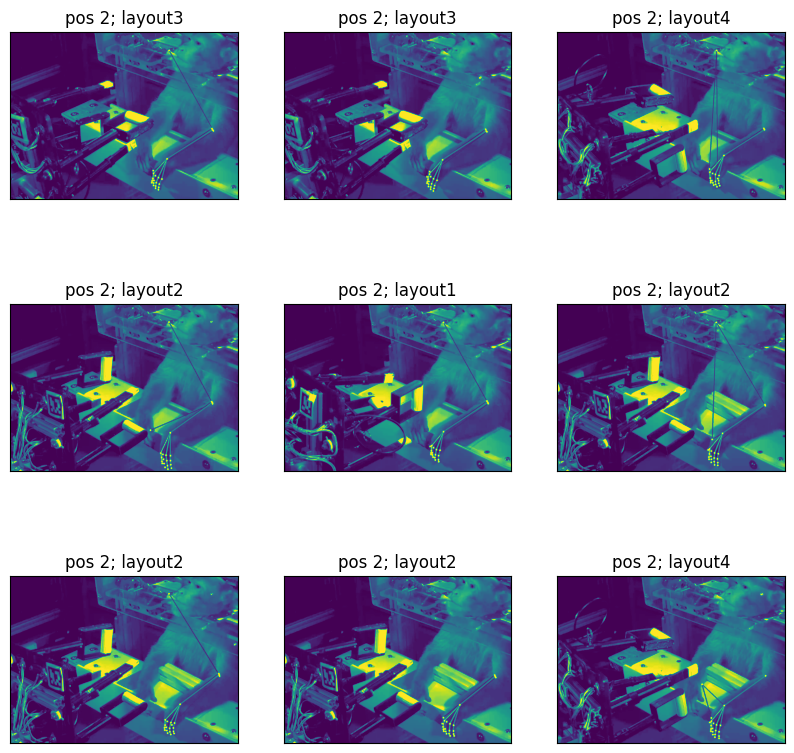

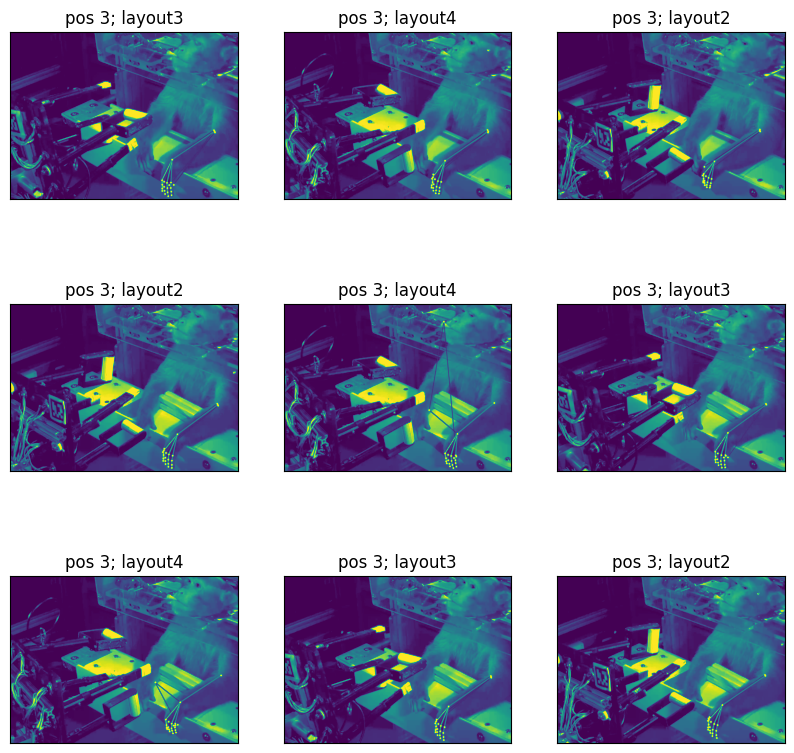

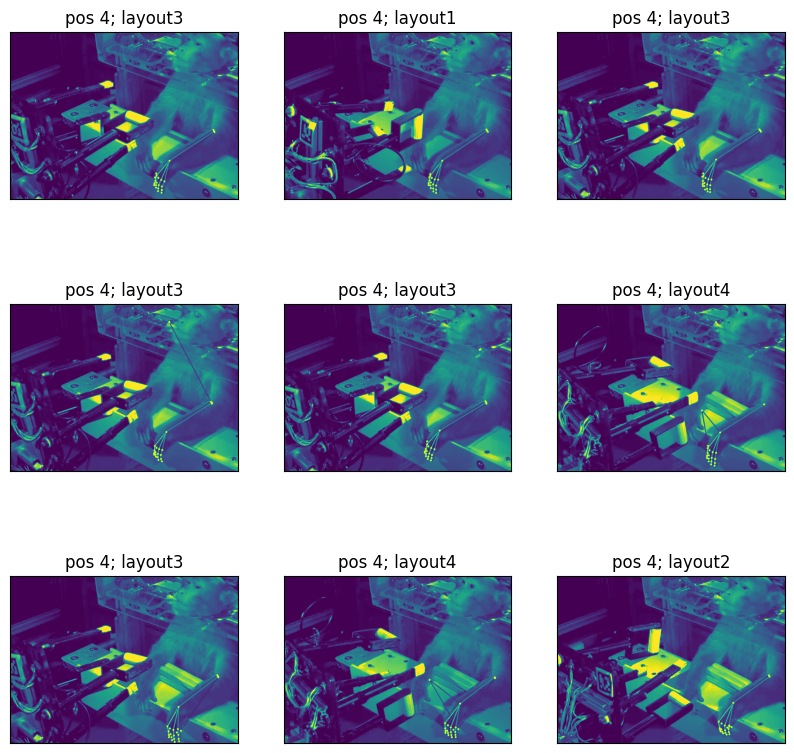

In [40]:
# for pos_idx in range(1,5):
#     plt.figure(figsize=(10,10))
#     pos_filter = np.where(position == pos_idx)[0]
#     for plot_idx in range(9):
#         idx = pos_filter[plot_idx] + 10

#         plt.subplot(3, 3, plot_idx + 1)
#         reader.seek(contact[idx] - cam_start + 0.0)
#         frame = next(reader)
#         plt.imshow(frame['data'].numpy()[0,:,:])
#         plt.title(f'pos {pos_idx}; layout{layout[idx]}')
#         plt.xticks([])
#         plt.yticks([])
#         #plt.tight_layout()
    